# K nearest neighbors

Implementaremos el algoritmo que vimos en la teoría, utilizando sklearn.

Sklearn tiene una implementación para KNN classifier: [documentación KNNClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Y otra para el regressor: [documentación KNNRegressor](
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)




In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Vamos a trabajar con el dataset penguins que podemos cargar desde seaborn.

La idea es que entrenemos un KNN para clasificar pinguinos (predecir la variable species)

In [48]:
df = sns.load_dataset("penguins")

In [49]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


¿ Hay nulos ?

In [50]:
#COMPLETAR
df.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

En caso de haberlos, por simplicidad los vamos a descartar.

Descartar nulos:

In [51]:
#COMPLETAR
df=df.dropna()

Dividimos en X e y

In [52]:
X = df.drop('species',axis=1)
y = df[['species']]

In [53]:
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male


In [54]:
y.head()

,species
0,Adelie
1,Adelie
2,Adelie
4,Adelie
5,Adelie


¿ Cuántos pinguinos tenemos de cada especie ?



In [55]:
y.value_counts()

species  
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

¿ Y en porcentajes ?

In [56]:
y.value_counts(normalize=True)

species  
Adelie       0.438438
Gentoo       0.357357
Chinstrap    0.204204
Name: proportion, dtype: float64

## Baseline

¿Cómo se les ocurre definir un baseline para este caso?

No hay una única manera correcta, tiene que ser un modelo simple.



In [57]:
# Lo más simple sería y='Adelie' ya que es la más frecuente.
Nuniq = y.value_counts().sum()
max = y.value_counts().max()

accuracy_scoreM=max/Nuniq
accuracy_scoreM

0.43843843843843844

El modelo que desarrollemos, tiene que ser mejor que este baseline. ¿ Qué accuracy_score tiene el baseline ?

In [58]:
from sklearn.metrics import accuracy_score

yp=np.array(['Adelie']*Nuniq)
accuracy_score(y,yp)

0.43843843843843844

## Train - test split

Como vimos la clase anterior, es importante guardarnos un conjunto de test para evaluar el modelo.

Vamos a hacer un train-test split utilizando sklearn.

primero, importar train_test_split de sklearn:

In [59]:
from sklearn.model_selection import train_test_split

Aplicar la función para obtener: X_train, X_test, y_train e y_test.

Vamos a tomar un 15% de los datos para el conjunto de test. Como las clases no están balanceadas, sería bueno utilizar el stratify que nos provee sklearn (vimos en el notebook de la clase pasada)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7, stratify=y)

In [61]:
X_train.shape

(283, 6)

In [62]:
X_test.shape

(50, 6)

In [63]:
y_train.shape

(283, 1)

In [64]:
y_test.shape

(50, 1)

## Preprocesamiento de datos

Vimos que en KNN es muy importante que los datos estén en una misma escala.

¿En que rango de valores se encuentran las variables numéricas del dataset?

In [65]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


Debemos llevar todo a una misma escala. Para esto utilizaremos el StandardScaler de sklearn.

Importar standard scaler:

In [66]:
from sklearn.preprocessing import StandardScaler

Crear una instancia de StandardScaler

In [67]:
scaler = StandardScaler()

Como siempre en Sklearn, tenemos que hacer un fit con nuestros datos de entrenamiento a el objeto.

Hacer un fit a el scaler con los datos NUMERICOS de train:
  
<span style='color:peru'>Se utiliza como base de normalización de la escala, el conjunto de entranamiento ya que se supone que el conjunto de test no se tiene en el momento del ajuste del modelo , sólo se tiene al momento de la predicción. Y si así se hiciera se estaría introduciendo información del conjunto de prueba en el mismo modelo, lo cual no es lógico. </span>

In [68]:
columnas_numericas = X.select_dtypes(include=['int', 'float']).columns.tolist()
columnas_numericas

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

In [69]:
scaler.fit(X_train[columnas_numericas])

StandardScaler()

Ahora, con el scaler podemos transformar los datos tanto en train como en test.

Transformar los datos numéricos de train (aplicar el scaler):

In [70]:
X_trainS=pd.DataFrame(scaler.transform(X_train[columnas_numericas]),columns=columnas_numericas)
X_testS=pd.DataFrame(scaler.transform(X_test[columnas_numericas]),columns=columnas_numericas)

In [71]:
X_trainS.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0.188433,-0.911925,1.381595,1.067669
1,-1.440420,0.054266,-1.018017,-1.115948
2,1.280504,0.969606,-0.363578,-0.804003
3,0.318000,-0.098290,-0.436293,-0.679225
4,-1.366381,0.308527,-1.163448,-0.616836


Ahora nos quedan 2 variables categóricas, vamos a aplicar one hot encoder.

Recuerden que el fit se hace sobre los datos de entrenamiento y luego sobre los datos de test aplicamos únicamente transform.

Importar one hot encoder:

In [72]:
from sklearn.preprocessing import OneHotEncoder

Instanciar one hot encoder para cada variable categórica:

In [73]:
ohe_island = OneHotEncoder(sparse_output=False)
ohe_sex = OneHotEncoder(sparse_output=False)
ohe_islandT = OneHotEncoder(sparse_output=False)
ohe_sexT = OneHotEncoder(sparse_output=False)

Hacer fit con los datos de entrenamiento para ambos encoders:

In [74]:
ohe_island.fit(X_train[['island']])
ohe_sex.fit(X_train[['sex']])
ohe_islandT.fit(X_test[['island']])
ohe_sexT.fit(X_test[['sex']])

OneHotEncoder(sparse_output=False)

Obtener las variables con one hot encoded para ambas variables categóricas:

In [75]:
islandE=ohe_island.transform(X_train[['island']])
sexE=ohe_sex.transform(X_train[['sex']])
df_island=pd.DataFrame(islandE,columns=ohe_island.get_feature_names_out())
df_sex=pd.DataFrame(sexE,columns=ohe_sex.get_feature_names_out())

islandTE=ohe_islandT.transform(X_test[['island']])
sexTE=ohe_sexT.transform(X_test[['sex']])
df_islandT=pd.DataFrame(islandTE,columns=ohe_islandT.get_feature_names_out())
df_sexT=pd.DataFrame(sexTE,columns=ohe_sexT.get_feature_names_out())

Hacer concat con X_train:

In [76]:
X_trainS=pd.concat([X_trainS.reset_index(drop=True),df_island,df_sex],axis=1)
X_trainS.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
0,0.188433,-0.911925,1.381595,1.067669,1.0,0.0,0.0,0.0,1.0
1,-1.440420,0.054266,-1.018017,-1.115948,0.0,1.0,0.0,1.0,0.0
2,1.280504,0.969606,-0.363578,-0.804003,0.0,1.0,0.0,0.0,1.0
3,0.318000,-0.098290,-0.436293,-0.679225,0.0,1.0,0.0,1.0,0.0
4,-1.366381,0.308527,-1.163448,-0.616836,0.0,0.0,1.0,1.0,0.0


In [77]:
X_testS=pd.concat([X_testS.reset_index(drop=True),df_islandT,df_sexT],axis=1)
X_testS.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
0,-0.144742,0.918754,-0.290862,0.724529,1.0,0.0,0.0,0.0,1.0
1,0.392039,0.511936,-1.672457,-1.178338,0.0,1.0,0.0,1.0,0.0
2,-0.996187,-0.098290,-0.945302,-1.615061,0.0,0.0,1.0,1.0,0.0
3,0.595646,-1.776413,0.945302,0.911696,1.0,0.0,0.0,1.0,0.0
4,0.558626,0.054266,-1.163448,-0.616836,0.0,1.0,0.0,1.0,0.0


descartar las columnas originales:

In [78]:
# X_train = X_train.drop(COMPLETAR, axis=COMPLETAR)
# X_train.head()

## KNN

Ahora, con nuestro dataset limpio, entrenemos un KNN classifier.

Primero, importar knn classifier de sklearn:

In [79]:
from sklearn.neighbors import KNeighborsClassifier

Instanciar un KNN con n_neighbors = 5 y weights="uniform".

INVESTIGAR: ¿Qué significa weights = "uniform" ???
  
<span style='color:peru'>El parámetro ***weights*** determina cómo se asignan los pesos a los puntos vecinos durante la votación para la predicción de la clase de un nuevo punto.
Cuando weights se establece en ***'uniform'***, significa que todos los vecinos ***tiene el mismo peso en la votación***.</span>

In [80]:
knnC = KNeighborsClassifier(n_neighbors=11, weights='uniform')

Entrenar el modelo con los datos de entrenamiento:

In [81]:
knnC.fit(X_trainS, y_train)

c:\Users\admin\Desktop\Icaro\Codigo\Resumen\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=11)

Generar las predicciones para train y test. Tener en cuenta que para generar las de test, debemos aplicar el preprocesamiento a los datos (OHE y scaler)

In [82]:
# Preprocesamiento test:
yptr = knnC.predict(X_trainS)
ypts = knnC.predict(X_testS)

In [83]:
# pred_train = #COMPLETAR
# pred_test = #COMPLETAR

Medir accuracy_score para train y test.

In [84]:
accuracy_score(yptr,y_train)

1.0

In [85]:
accuracy_score(ypts,y_test)#COMPLETAR

0.98

Vemos que las métricas obtenidas van a ser bastante altas. Este es un dataset simple.

Cuando trabajemos con datasets más complejos, podemos hacer un bucle for y entrenar muchos KNN con distintos valores de n_neighbors. Para cada valor de n_neighbors, calcular las métricas en train y test y luego graficarlas para encontrar el mejor valor de n_neighbors. Hay distintas técnicas para encontrar el mejor valor de hiperparámetros pero en general todas se basan en prueba/error. Veremos esto más adelante.

Optimización de de n_neighbors.

In [86]:
X_comb = pd.concat([X_trainS, X_testS], axis=0)
y_comb = pd.concat([y_train, y_test], axis=0)

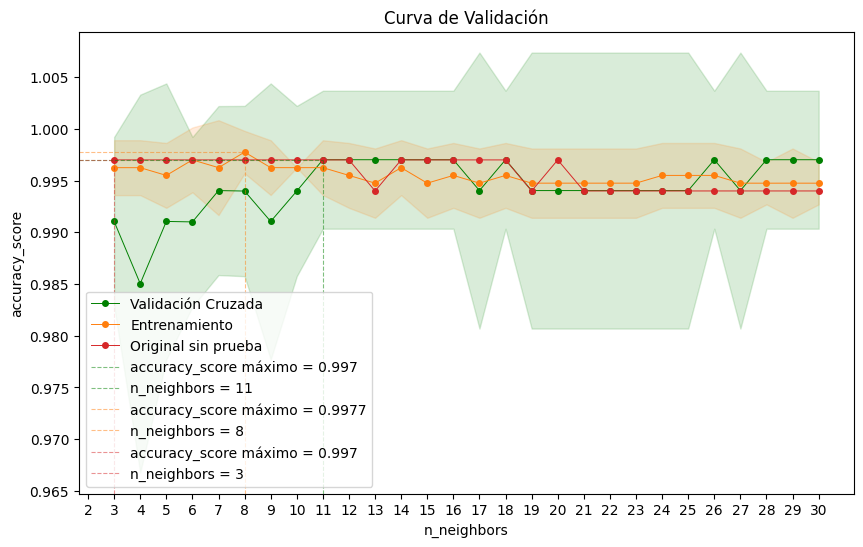

In [87]:
from f_func import bestParam
from sklearn.metrics import mean_squared_error

_=bestParam(X_comb,y_comb,knnC,['n_neighbors',3,30],accuracy_score,maxim=1,cv=5,g=1,fig=(10,6),colores=['green','#FF7F0E','#D62728'])

